In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import decoupler
import pandas as pd
import numpy as np
import random
import sc_toolbox

from scipy.sparse import csr_matrix, isspmatrix
from datetime import datetime

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

In [3]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import visualise as vs
from src.utils import utils as us
%load_ext autoreload
%autoreload 2

In [4]:
sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()
time_start = datetime.now()
%load_ext rpy2.ipython
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
%%R
library(edgeR)
library(limma)
# library(MAST)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


Loading required package: limma
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


# Load Data

In [6]:
adata = sc.read(config.PATHS.LOGS/'Norm.h5ad')

print(adata.shape)
print('isspmatrix:', isspmatrix(adata.X))


print('Loaded Filtered AnnData object: number of cells', adata.n_obs)
print('Loaded Filtered AnnData object: number of genes', adata.n_vars) 
print('Available metadata for each cell: ', adata.obs.columns)

(24549, 15223)
isspmatrix: True
Loaded Filtered AnnData object: number of cells 24549
Loaded Filtered AnnData object: number of genes 15223
Available metadata for each cell:  Index(['timepoint', 'line', '10X_date', 'clusters', 'tSNE_1', 'tSNE_2',
       'cluster', 'timepoint_mapped', 'batch', 'dataset', 'isHuman', 'isESC',
       'n_genes_by_counts', 'total_counts', 'total_counts_mito',
       'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo',
       'QC_doublets', 'n_genes', 'n_counts'],
      dtype='object')


In [7]:
pd.crosstab(adata.obs['line'], adata.obs['timepoint_mapped'], margins=True)

timepoint_mapped,14,28,35,All
line,,,,
409b2,1431,5016,2456,8903
h9,694,0,5953,6647
joc,275,0,105,380
sandraA,1763,729,1669,4161
sc102a1,956,0,3502,4458
All,5119,5745,13685,24549


In [8]:
adata.obs['time'] = adata.obs.timepoint_mapped.apply(
    lambda x: 'd{}'.format(x)).copy()
adata.obs['isHuman'] = adata.obs.line.apply(
    lambda x: x.lower() in config.HUMANS).copy()

In [9]:
adata.obs['sample'] = adata.obs.line.astype(str) \
    + '_' + adata.obs.batch.astype(str) \
    + '_' + adata.obs.timepoint_mapped.astype(str)

In [10]:
obs_to_keep = ["sample", "cluster", "batch", "line", "time", "isHuman"]

In [11]:
# to pass the raw counts to edgeR .X is set 
# to the counts layer to ensure the pseudo-replicates
# are created for raw counts.
# adata.layers['counts'] = adata.X.copy()
if config.PROTO.SUBSET.USE_HIGHLY_VARIABLE:
    adata = adata[:, adata.var.highly_variable]
adata.X = adata.layers["counts"].copy()

In [12]:
adata

View of AnnData object with n_obs × n_vars = 24549 × 1585
    obs: 'timepoint', 'line', '10X_date', 'clusters', 'tSNE_1', 'tSNE_2', 'cluster', 'timepoint_mapped', 'batch', 'dataset', 'isHuman', 'isESC', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'QC_doublets', 'n_genes', 'n_counts', 'time', 'sample'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'line_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_triku'
    varm: 'PCs'
    layers: 'counts', 'lognormcounts'
    obsp: 'connectivities', 'distances'

# Exclude Non-Human

In [13]:
adata.obs.time.value_counts()

time
d35    13685
d28     5745
d14     5119
Name: count, dtype: int64

In [14]:
idxs = np.prod([
    adata.obs.time.apply(lambda x: x in [ 'd14']),#, 'd35' ]),
    # adata.obs.line.apply(lambda x: x.lower() in config.HUMANS),
], axis=0, dtype=np.bool_)
selected = adata[idxs, :].copy()
selected.obs.head()

,timepoint,line,10X_date,clusters,tSNE_1,tSNE_2,cluster,timepoint_mapped,batch,dataset,...,total_counts,total_counts_mito,pct_counts_mito,total_counts_ribo,pct_counts_ribo,QC_doublets,n_genes,n_counts,time,sample
AAACCTGAGTACTTGC-9.w2_409b2_171212,w2,409b2,171212,C5,45.486102,-28.756658,C5,14,171212_b1,EMATB,...,7029,170,2.418552,1754,24.953763,0.046940,2431,7029,d14,409b2_171212_b1_14
AAACCTGCACGGCCAT-9.w2_409b2_171212,w2,409b2,171212,C7,36.626131,6.664266,C7,14,171212_b1,EMATB,...,7490,174,2.323097,1743,23.271028,0.054152,2570,7490,d14,409b2_171212_b1_14
AAACCTGCAGTATCTG-9.w2_409b2_171212,w2,409b2,171212,C5,36.483634,-26.967325,C5,14,171212_b1,EMATB,...,6411,226,3.525191,1417,22.102636,0.037138,2437,6411,d14,409b2_171212_b1_14
AAACCTGGTTTAAGCC-9.w2_409b2_171212,w2,409b2,171212,C7,35.570214,34.445170,C7,14,171212_b1,EMATB,...,8042,334,4.153196,1858,23.103706,0.063313,2749,8042,d14,409b2_171212_b1_14
AAACGGGCACGCCAGT-9.w2_409b2_171212,w2,409b2,171212,C5,36.968570,-28.070171,C5,14,171212_b1,EMATB,...,5274,144,2.730375,1199,22.734168,0.036585,2128,5274,d14,409b2_171212_b1_14


In [15]:
if config.PROTO.PSEUDO_BULK.TYPE == 'decoupler':
    adata_pb = decoupler.get_pseudobulk(
        adata, 'sample', 'cluster', adata.obs,
        min_cells=config.PROTO.GLM.MIN_CELLS,
        mode=config.PROTO.GLM.PSEUDOBULK_MODE)
else:
    # process first cell type separately...
    adata_pb = None
    for i, cell_type in enumerate(
        selected.obs["cluster"].cat.categories):
        print(f'Processing {cell_type} ({i+1} out of {len(adata.obs["cluster"].cat.categories)})...')

        adata_ct = us.aggregate_with_replace(selected, cell_type, obs_to_keep=obs_to_keep)
        adata_pb = adata_ct if adata_pb is None else adata_pb.concatenate(adata_ct)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/anndata/_core/anndata.py:447: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


32.0

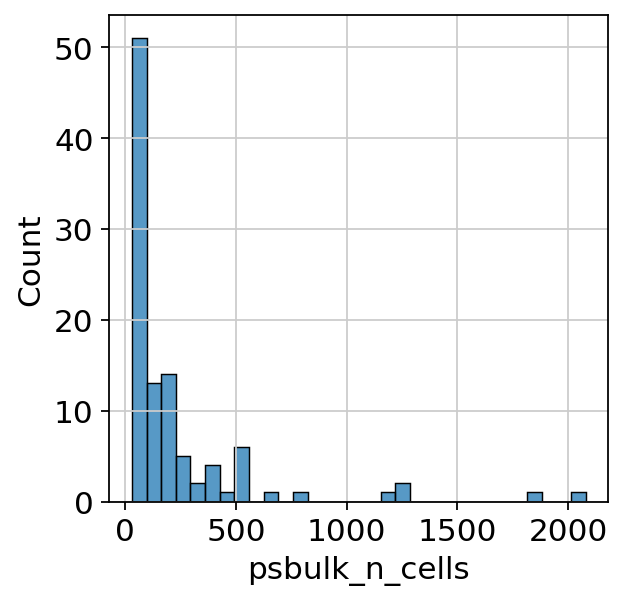

In [16]:
sns.histplot(
    adata_pb.obs.psbulk_n_cells)
np.percentile(adata_pb.obs.psbulk_n_cells, 5)

In [17]:
adata_pb.layers['icounts'] = adata_pb.X.copy()

sc.pp.normalize_total(
    adata_pb, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

Unnamed: 0
NDUFB8    0.077523
HMP19     0.079635
CD24      0.081157
UQCR11    0.085781
NEFL      0.093508
Name: pca, dtype: float32

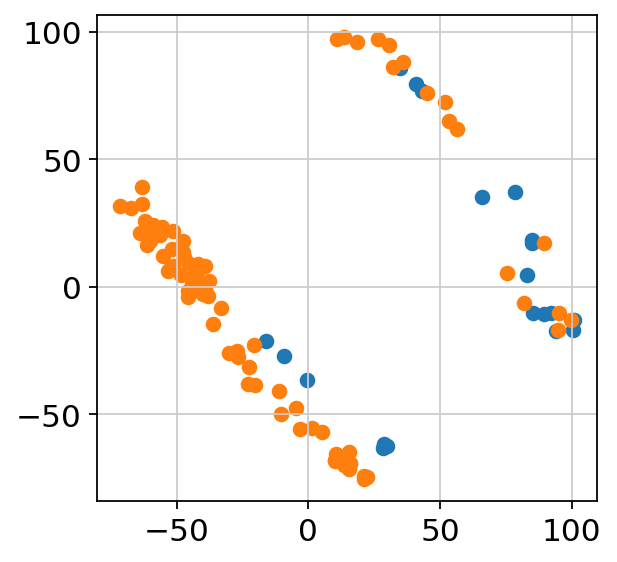

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(adata_pb.X)
adata_pb.var['pca'] = pca.components_[0]
pca = np.abs(adata_pb.var['pca'])

plt.scatter(adata_pb[adata_pb.obs.line == 'h9'].obsm['X_pca'][:, 0], adata_pb[adata_pb.obs.line == 'h9'].obsm['X_pca'][:, 1]);
plt.scatter(adata_pb[adata_pb.obs.line != 'h9'].obsm['X_pca'][:, 0], adata_pb[adata_pb.obs.line != 'h9'].obsm['X_pca'][:, 1]);
pca.sort_values()[-5:]

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


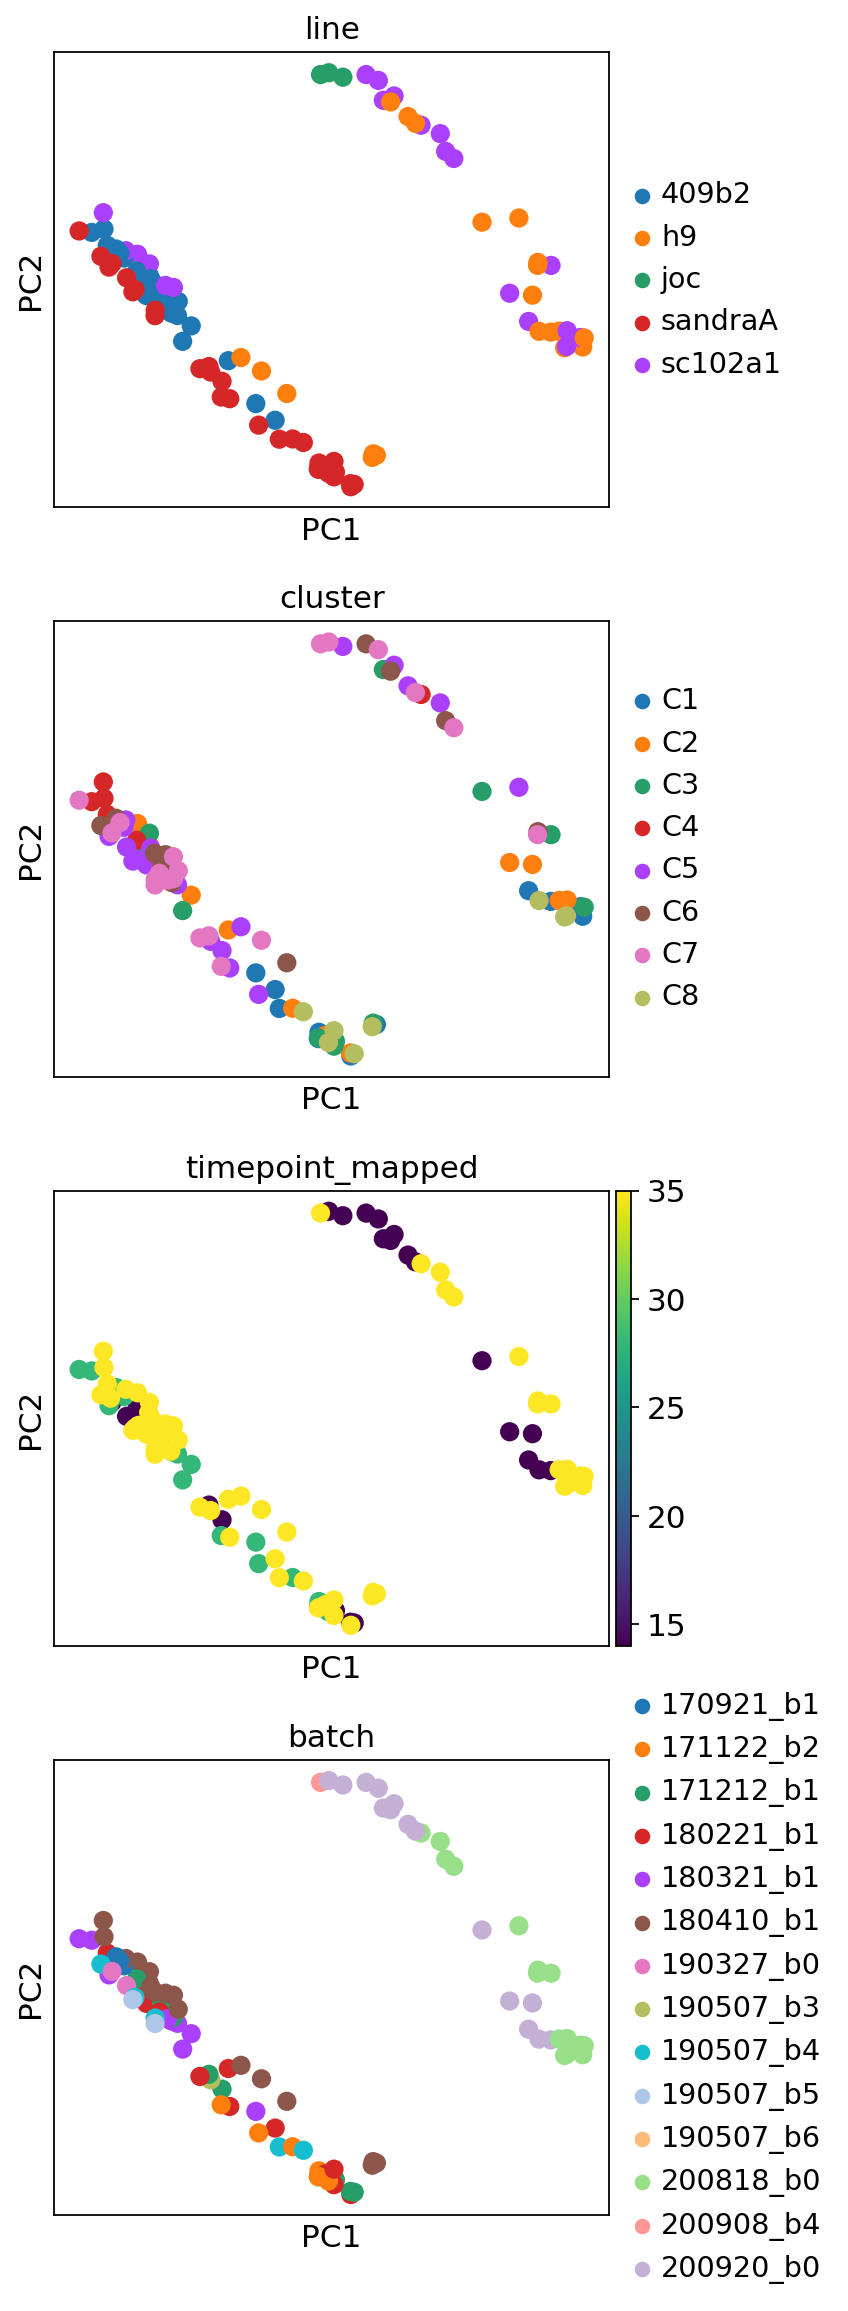

In [19]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["icounts"], axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].astype(float))

sc.pl.pca(adata_pb, color=['line', 'cluster', 'timepoint_mapped', 'batch'], ncols=1, size=300)

In [20]:
adata_pb.X = adata_pb.layers['icounts'].copy()

# edgeR

In [21]:
# adata_mono = adata_pb[
#     (adata_pb.obs["cluster"] == "C2") |
#     (adata_pb.obs["cluster"] == "C3")]..copy()
adata_mono = adata_pb.copy()
# adata_mono.obs = adata_mono.obs.drop(columns=['Cluster'])
# Clean the sample names to make plots less crowded.
# adata_mono.obs_names = [
#     name.split("_")[2] + "_" + name.split("_")[3] for name in adata_mono.obs_names
# ]
adata_mono

AnnData object with n_obs × n_vars = 103 × 1585
    obs: 'timepoint', 'line', '10X_date', 'clusters', 'cluster', 'timepoint_mapped', 'batch', 'dataset', 'isHuman', 'isESC', 'time', 'sample', 'psbulk_n_cells', 'psbulk_counts', 'lib_size', 'log_lib_size'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable', 'pca'
    uns: 'log1p', 'pca', 'line_colors', 'cluster_colors', 'batch_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'icounts'

In [22]:
from anndata2ri import converter
import scipy


# adata_mono.X = scipy.sparse.csc_matrix(adata_mono.X.astype(float))
# adata_mono.layers['icounts'] = scipy.sparse.csc_matrix(
#     adata_mono.layers['icounts'].astype(float))

# adata_mono.obsm['X_pca'] = scipy.sparse.csc_matrix(
#     adata_mono.obsm['X_pca'].astype(float))
# adata_mono.varm['PCs'] = scipy.sparse.csc_matrix(
#     adata_mono.varm['PCs'].astype(float))
# adata_mono.uns['pca']['variance'] = scipy.sparse.csc_matrix(
#     adata_mono.uns['pca']['variance'].astype(float))
# adata_mono.uns['pca']['variance_ratio'] = scipy.sparse.csc_matrix(
#     adata_mono.uns['pca']['variance_ratio'].astype(float))
# adata_mono.uns['pca']['variance_ratio']

In [23]:
adata_mono.obs.lib_size = adata_mono.obs.lib_size.astype(float)
adata_mono.obs.log_lib_size = adata_mono.obs.log_lib_size.astype(float)

In [24]:
adata_mono.obs.head()

,timepoint,line,10X_date,clusters,cluster,timepoint_mapped,batch,dataset,isHuman,isESC,time,sample,psbulk_n_cells,psbulk_counts,lib_size,log_lib_size
409b2_180221_b1_35_C1,w5,409b2,180221,C1,C1,35,180221_b1,EMATB,True,False,d35,409b2_180221_b1_35,35.0,8321.0,8321.0,9.026538
409b2_180321_b1_28_C1,w4,409b2,180321,C1,C1,28,180321_b1,EMATB,True,False,d28,409b2_180321_b1_28,327.0,34488.0,34488.0,10.448367
h9_180410_b1_35_C1,w5,h9,180410,C1,C1,35,180410_b1,EMATB,True,True,d35,h9_180410_b1_35,91.0,29908.0,29908.0,10.305881
h9_200818_b0_35_C1,d35,h9,200818,C1,C1,35,200818_b0,EMATB,True,True,d35,h9_200818_b0_35,1242.0,1072960.0,1072960.0,13.885932
h9_200920_b0_14_C1,d14,h9,200920,C1,C1,14,200920_b0,EMATB,True,True,d14,h9_200920_b0_14,85.0,58723.0,58723.0,10.980587


In [25]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group=colData(adata_)$isHuman)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$time, ".", colData(adata_)$cluster)
    replicate <- paste0(colData(adata_)$line, ".", colData(adata_)$replicate)
    isHuman <- paste0(colData(adata_)$isHuman)#, ".", colData(adata_)$time)
    design <- model.matrix(~ 0 + isHuman)
    # estimate dispersion
    y <- estimateDisp(y, design=design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [26]:
%%time
%%R -i adata_mono --converter anndata2ri.converter
outs <- fit_model(adata_mono)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28

[1] "Dimensions before subsetting:"
[1] 1585  103
[1] ""
[1] "Dimensions after subsetting:"
[1] 493 103
[1] ""


/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


CPU times: user 5.75 s, sys: 187 ms, total: 5.94 s
Wall time: 5.93 s


In [27]:
%%R
fit <- outs$fit
y <- outs$y

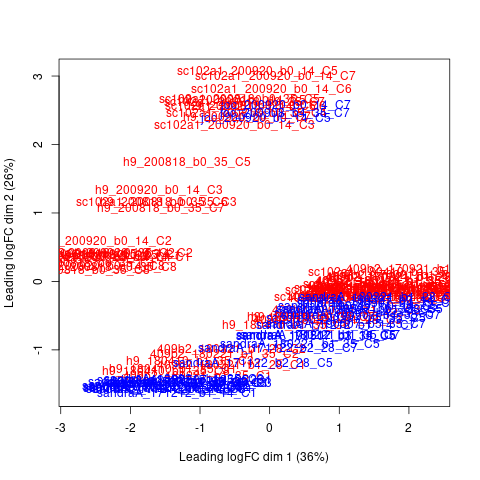

In [28]:
%%R
plotMDS(y, col=ifelse(y$samples$group == TRUE, "red", "blue"))

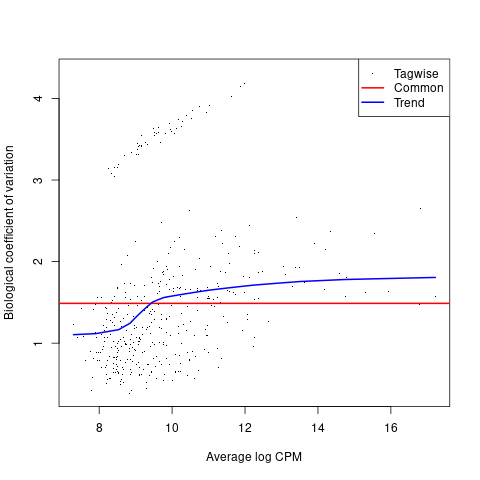

In [29]:
%%R
plotBCV(y)

In [30]:
%%R
colnames(y$design)

[1] "isHumanFALSE" "isHumanTRUE" 


In [31]:
%%R -o tt
myContrast <- makeContrasts("isHumanTRUE-isHumanFALSE", levels=y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [32]:
tt.shape
tt[:15]

,logFC,logCPM,F,PValue,FDR
AC074183.4,-7.781034,8.851686,397.048949,1.215320e-37,4.212451e-35
BX255923.3,-8.057944,9.116660,393.833498,1.708905e-37,4.212451e-35
TRABD2A,-4.739260,8.915337,204.281970,1.777339e-26,2.920760e-24
MTRNR2L12,-4.100173,12.222104,173.092234,5.031510e-24,6.201336e-22
MEIG1,-4.296967,9.086510,149.160008,6.003525e-22,5.919476e-20
MEIOB,-5.492880,9.243290,144.998218,1.443930e-21,1.186429e-19
NPIPB15,-4.779155,9.836153,140.240528,4.010202e-21,2.824328e-19
TUBA1C,-3.854475,11.915084,135.370507,1.165020e-20,7.179434e-19
CHKB-AS1,-2.897880,9.575152,121.226908,2.931864e-19,1.606010e-17
MTRNR2L8,-3.980477,11.934362,106.964379,9.382562e-18,4.625603e-16


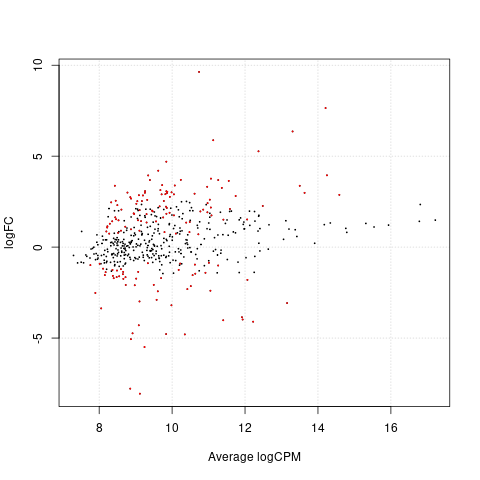

In [33]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR< .01)])

# Visualisation

In [34]:
selected.X = selected.layers["counts"].copy()
sc.pp.normalize_total(selected, target_sum=1e6)
sc.pp.log1p(selected)

In [35]:
FDR = 0.01
LOG_FOLD_CHANGE = 3.5


def plot_heatmap(
    adata, group_key, group_name="cluster", groupby="isHuman"):
    cell_type = "_".join(group_key.split("_")[1:])
    res = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key)
    res.index = res["names"].values
    res = res[
        (res["pvals_adj"] < FDR) & (abs(res["logfoldchanges"]) > LOG_FOLD_CHANGE)
    ].sort_values(by=["logfoldchanges"])
    print(f"Plotting {len(res)} genes...")
    markers = list(res.index)
    sc.pl.heatmap(
        adata,#[adata.obs[group_name] == cell_type].copy(),
        markers,
        groupby=[groupby, 'line'],
        swap_axes=True,
    )
    return markers

In [36]:
# add the table to .uns for each cell type
cell_type = 'C2+C3'
tt["gene_symbol"] = tt.index
tt["cluster"] = cell_type
sc_toolbox.tools.de_res_to_anndata(
    selected,
    tt,
    groupby="cluster",
    score_col="logCPM",
    pval_col="PValue",
    pval_adj_col="FDR",
    lfc_col="logFC",
    key_added="edgeR_" + cell_type,
)

In [37]:
ranked = sc.get.rank_genes_groups_df(
    selected, group="C2+C3", key="edgeR_C2+C3")

tmp = ranked.sort_values(by='scores')
tmp[(tmp.logfoldchanges >= 1)|(tmp.logfoldchanges <= -1)]

,names,scores,logfoldchanges,pvals,pvals_adj
479,B3GLCT,7.895681,-2.520018,0.0,0.000002
468,CTSF,8.054922,-3.368445,0.0,0.0
464,IGFBP4,8.106749,-1.18582,0.000474,0.002104
458,NOTCH3,8.154899,-1.538271,0.000017,0.000125
456,TK1,8.176581,-1.377704,0.001242,0.004822
...,...,...,...,...,...
4,UQCR11,15.538357,1.105848,0.15946,0.229865
3,SNCG,15.936062,1.212703,0.044656,0.082198
2,GAP43,16.780369,1.416998,0.009485,0.025413
1,NEFL,16.805594,2.342834,0.168932,0.240716


Plotting 26 genes...


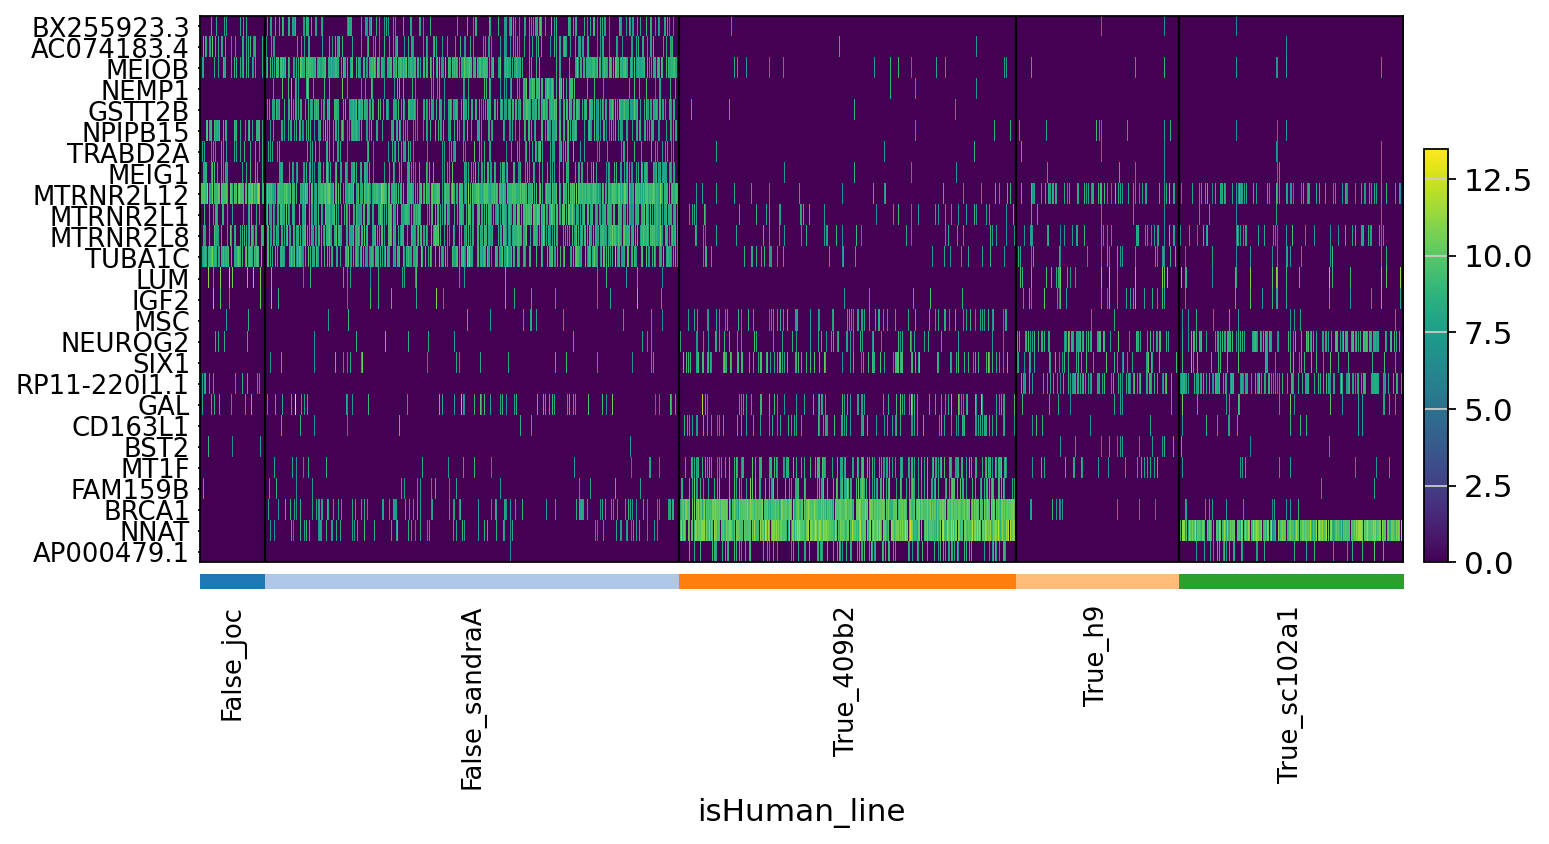

In [40]:
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = plot_heatmap(selected, "edgeR_C2+C3")

Plotting 155 genes...


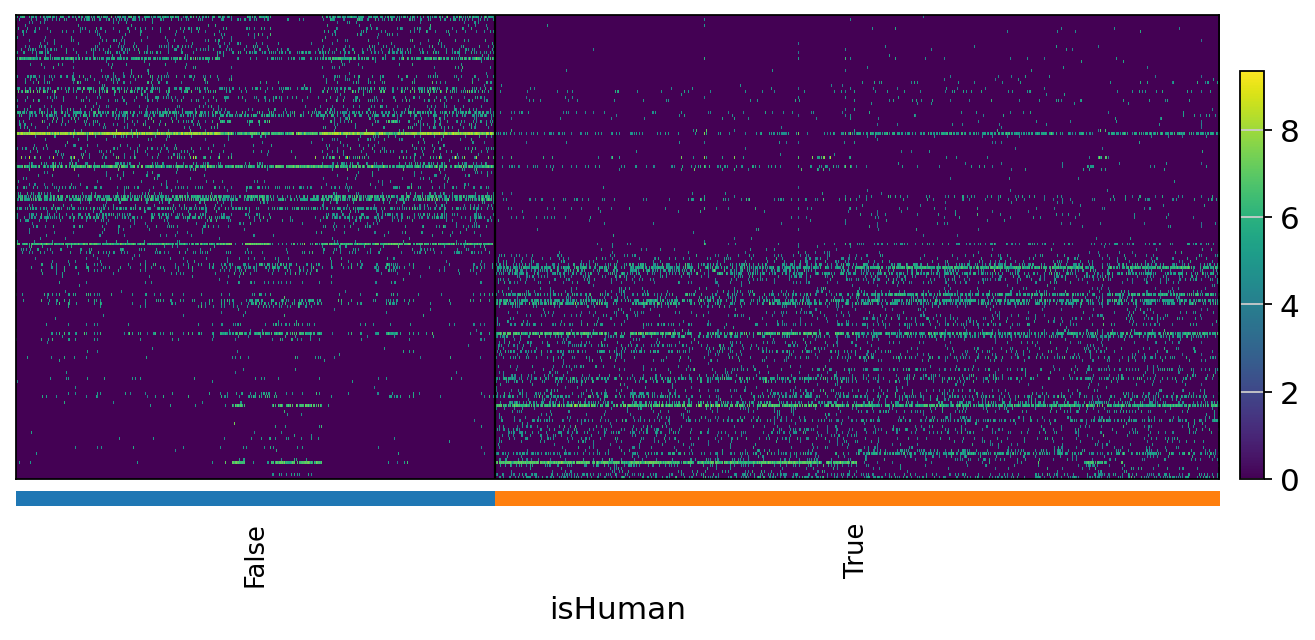

In [78]:
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = plot_heatmap(selected, "edgeR_C2+C3")

In [39]:
print(markers)

['BX255923.3', 'AC074183.4', 'MEIOB', 'NEMP1', 'GSTT2B', 'NPIPB15', 'TRABD2A', 'MEIG1', 'MTRNR2L12', 'MTRNR2L1', 'MTRNR2L8', 'TUBA1C', 'LUM', 'IGF2', 'MSC', 'NEUROG2', 'SIX1', 'RP11-220I1.1', 'GAL', 'CD163L1', 'BST2', 'MT1F', 'FAM159B', 'BRCA1', 'NNAT', 'AP000479.1']


In [41]:
LOG_FOLD_CHANGE = 1.5


def volcano_plot(adata, group_key, group_name="clusters", groupby="time", title=None):
    cell_type = "_".join(group_key.split("_")[1:])
    result = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key).copy()
    result["-logQ"] = -np.log(result["pvals"].astype("float"))
    lowqval_de = result.loc[abs(result["logfoldchanges"]) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result["logfoldchanges"]) <= LOG_FOLD_CHANGE]

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.regplot(
        x=other_de["logfoldchanges"],
        y=other_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    sns.regplot(
        x=lowqval_de["logfoldchanges"],
        y=lowqval_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    ax.set_xlabel("log2 FC")
    ax.set_ylabel("-log Q-value")

    if title is None:
        title = group_key.replace("_", " ")
    plt.title(title)
    plt.show()

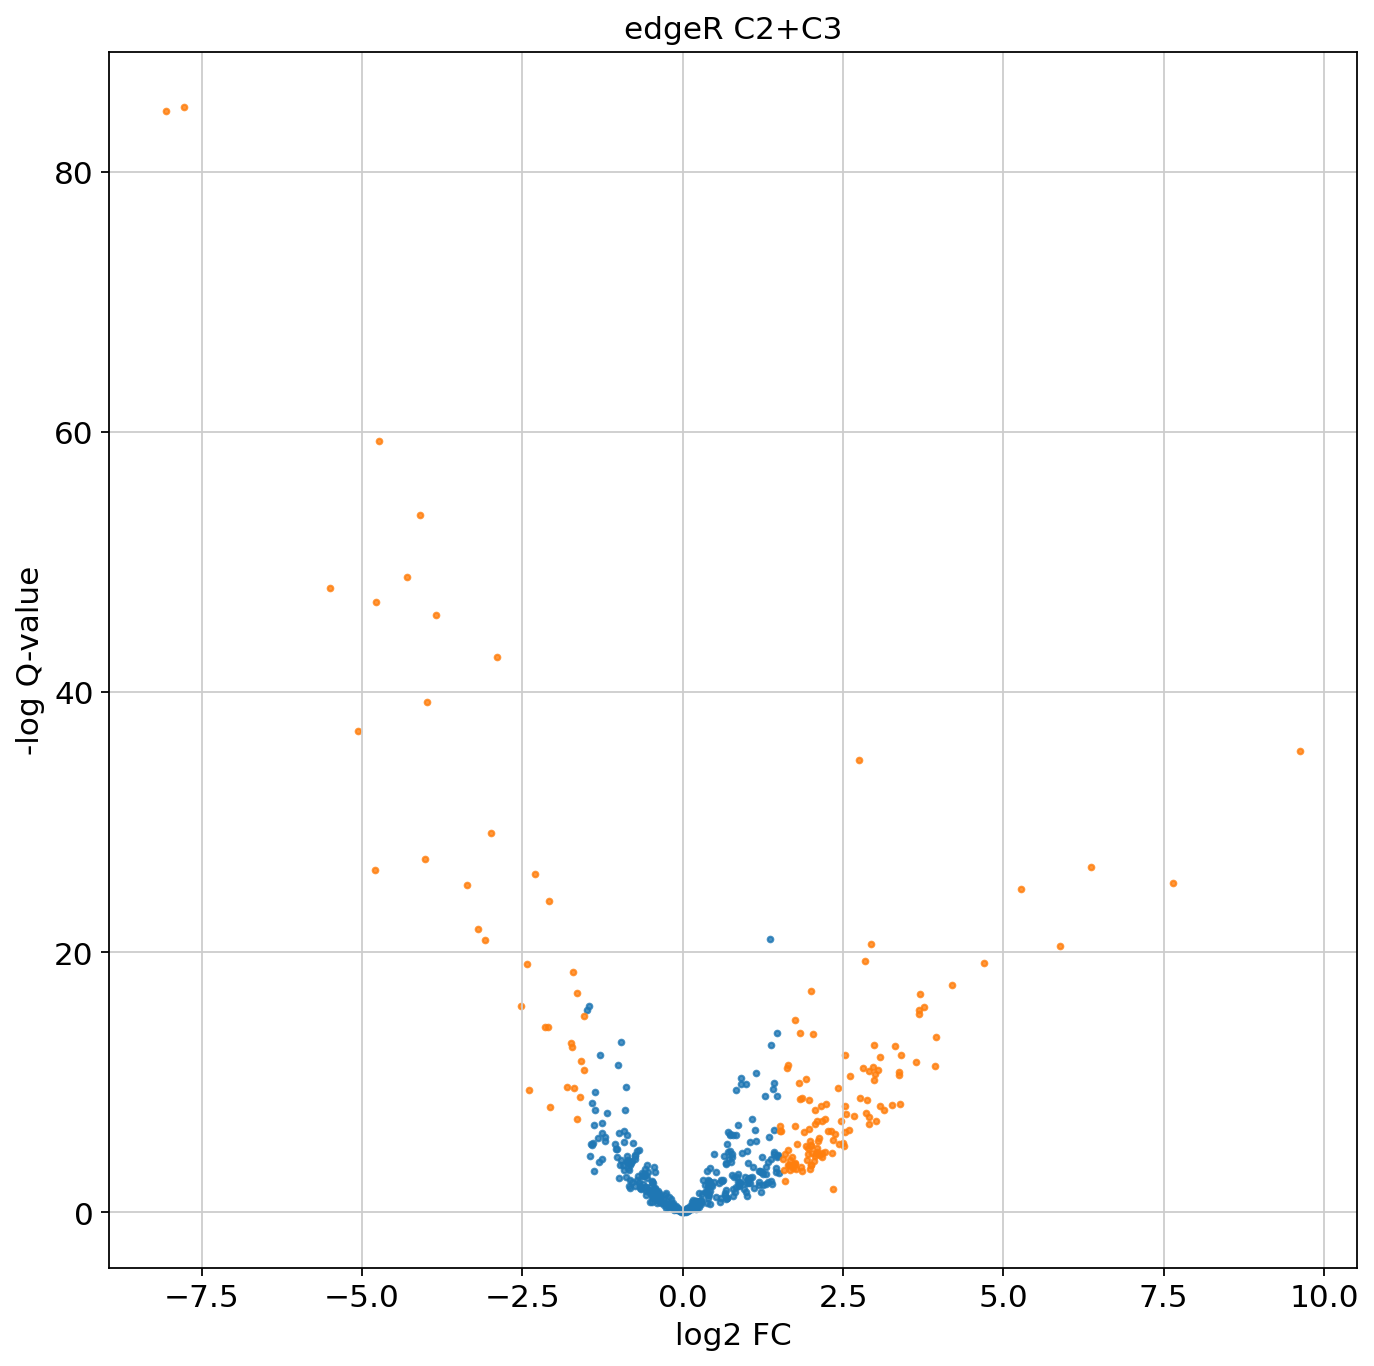

In [42]:
volcano_plot(selected, "edgeR_C2+C3")

In [46]:
tmp.to_csv(config.PATHS.LOGS/'markers.csv')

In [43]:
from anndata2ri import converter
import scipy


adata_pb.X = scipy.sparse.csc_matrix(adata_pb.X.astype(float))
adata_pb.layers['counts'] = scipy.sparse.csc_matrix(
    adata_pb.layers['counts'].astype(float))

adata_pb.obsm['X_pca'] = scipy.sparse.csc_matrix(
    adata_pb.obsm['X_pca'].astype(float))
adata_pb.varm['PCs'] = scipy.sparse.csc_matrix(
    adata_pb.varm['PCs'].astype(float))
adata_pb.uns['pca']['variance'] = scipy.sparse.csc_matrix(
    adata_pb.uns['pca']['variance'].astype(float))
adata_pb.uns['pca']['variance_ratio'] = scipy.sparse.csc_matrix(
    adata_pb.uns['pca']['variance_ratio'].astype(float))
adata_pb.uns['pca']['variance_ratio']

<1x50 sparse matrix of type '<class 'numpy.float64'>'
	with 50 stored elements in Compressed Sparse Column format>

In [44]:
adata_pb.obs.lib_size = adata_pb.obs.lib_size.astype(float)
adata_pb.obs.log_lib_size = adata_pb.obs.log_lib_size.astype(float)

In [45]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$Gestation_week)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$Gestation_week, ".", colData(adata_)$Cluster)
    # replicate <- colData(adata_)$replicate
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    # design <- model.matrix(~ 0 + group + replicate)
    # group <- colData(adata_)$Gestation_week
    design <- model.matrix(~ 0 + group)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [46]:
%%time
%%R -i adata_pb
outs <-fit_model(adata_pb)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28

[1] "Dimensions before subsetting:"
[1] 13945   162
[1] ""
[1] "Dimensions after subsetting:"
[1] 6133  162
[1] ""
CPU times: user 21.3 s, sys: 119 ms, total: 21.5 s
Wall time: 21.5 s


In [47]:
%%R
fit <- outs$fit
y <- outs$y
colnames(y$design)

 [1] "groupa17.0.aEnd"   "groupa17.0.aExDp1" "groupa17.0.aExDp2"
 [4] "groupa17.0.aExM"   "groupa17.0.aExMU"  "groupa17.0.aExN"  
 [7] "groupa17.0.aInCGE" "groupa17.0.aInMGE" "groupa17.0.aIP"   
[10] "groupa17.0.aOPC"   "groupa17.0.aoRG"   "groupa17.0.aPer"  
[13] "groupa17.0.aPgG2M" "groupa17.0.aPgS"   "groupa17.0.avRG"  
[16] "groupa18.0.aEnd"   "groupa18.0.aExDp1" "groupa18.0.aExDp2"
[19] "groupa18.0.aExM"   "groupa18.0.aExMU"  "groupa18.0.aExN"  
[22] "groupa18.0.aInCGE" "groupa18.0.aInMGE" "groupa18.0.aIP"   
[25] "groupa18.0.aOPC"   "groupa18.0.aoRG"   "groupa18.0.aPer"  
[28] "groupa18.0.aPgG2M" "groupa18.0.aPgS"   "groupa18.0.avRG"  


In [48]:
%%R -i adata_pb -o de_per_cell_type
de_per_cell_type <- list()
for (cell_type in unique(colData(adata_pb)$Cluster)) {
    print(cell_type)
    # create contrast for this cell type
    myContrast <- makeContrasts(paste0("groupa17.0.", cell_type, "-groupa18.0.", cell_type), levels = y$design)
    # perform QLF test
    qlf <- glmQLFTest(fit, contrast=myContrast)
    # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
    tt <- topTags(qlf, n = Inf)
    # save in the list with the results for all the cell types
    de_per_cell_type[[cell_type]] <- tt$table
}


[1] "aEnd"
[1] "aExDp1"
[1] "aExDp2"
[1] "aExM"
[1] "aExMU"
[1] "aExN"
[1] "aIP"
[1] "aInCGE"
[1] "aInMGE"
[1] "aOPC"
[1] "aPer"
[1] "aPgG2M"
[1] "aPgS"
[1] "aoRG"
[1] "avRG"


In [49]:
de_per_cell_type.keys()

('aEnd',
 'aExDp1',
 'aExDp2',
 'aExM',
 'aExMU',
 'aExN',
 'aIP',
 'aInCGE',
 'aInMGE',
 'aOPC',
 'aPer',
 'aPgG2M',
 'aPgS',
 'aoRG',
 'avRG')

In [50]:
adata.var

,mito,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,triku_distance,triku_distance_uncorrected,triku_highly_variable
TSPAN6,False,False,1730,0.059012,94.908170,2005.0,1609,False,1.154860,1.919698,False
DPM1,False,False,3240,0.109636,90.463857,3725.0,3032,False,-0.203073,0.703431,False
SCYL3,False,False,628,0.020985,98.151636,713.0,589,False,-0.452759,0.261193,False
C1orf112,False,False,324,0.010036,99.046386,341.0,307,False,0.387194,1.145945,False
FUCA2,False,False,767,0.025135,97.742524,854.0,724,False,1.183910,1.791661,False
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000219391,False,False,187,0.005504,99.449611,187.0,178,False,-0.022842,0.583615,False
TTTY15,False,False,932,0.032906,97.256887,1118.0,852,True,3.342773,3.981962,True
ENSG00000248200,False,False,197,0.005798,99.420179,197.0,184,False,0.125864,0.732321,False
TTTY14,False,False,229,0.007240,99.325995,246.0,218,False,1.353395,1.879533,False


In [51]:
# get cell types that we ran the analysis for
cell_types = de_per_cell_type.keys()
# add the table to .uns for each cell type
for cell_type in cell_types:
    df = de_per_cell_type[cell_type]
    df["gene_symbol"] = df.index
    df["cell_type"] = cell_type
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        df,
        groupby="Cluster",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + cell_type,
    )
    df.to_csv(f"de_edgeR_{cell_type}.csv")

ValueError: groupby column must exist in both adata and de_res. 

In [ ]:
sc.get.rank_genes_groups_df(adata, group="CD14_Monocytes", key="edgeR_CD14_Monocytes")[
    :5
]